<a href="https://colab.research.google.com/github/nobertomaciel/PLN-ANIMA/blob/main/UA2/PLN_speech_recognition_validation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Envie um arquivo de áudio (wav/mp3/m4a):


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Saving F042-0000.mp3 to F042-0000 (1).mp3
Carregando modelo Whisper...
Transcrevendo áudio...

=== TRANSCRIÇÃO FINAL ===

 Pesquisa é uma coisa que muda toda a hora.

Arquivo salvo como: F042-0000 (1).mp3.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Digite a transcrição verdadeira do áudio para referência da validação (ground truth):
Pesquisa é uma coisa que muda toda a hora.

=== MÉTRICAS DE AVALIAÇÃO ===

WER  (Word Error Rate): 0.0
CER  (Character Error Rate): 0.0
BLEU Score: 1.0
Acurácia (char-level): 1.0
F1-score (char-level): 1.0


<Figure size 800x600 with 0 Axes>

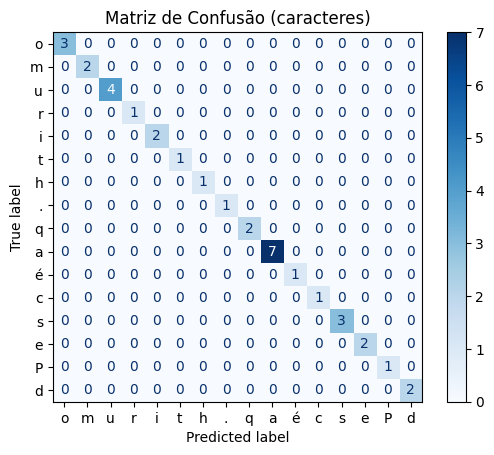

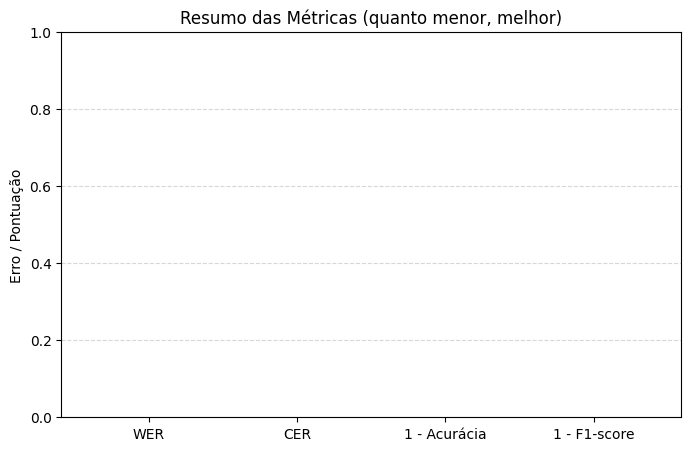


Avaliação concluída!


In [2]:
# ==============================================================
# SISTEMA COMPLETO DE RECONHECIMENTO DE VOZ COM WHISPER + MÉTRICAS
# ==============================================================

# 1) Instalar dependências
!pip install -q openai-whisper ffmpeg-python jiwer nltk scikit-learn matplotlib

import whisper
from google.colab import files
from jiwer import wer, cer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import numpy as np
import nltk

nltk.download('punkt')

# ==============================================================
# 2) Upload do arquivo de áudio
# ==============================================================
print("Envie um arquivo de áudio (wav/mp3/m4a):")
uploaded = files.upload()
audio_path = list(uploaded.keys())[0]

# ==============================================================
# 3) Carregar modelo
# ==============================================================
print("Carregando modelo Whisper...")
model = whisper.load_model("small")   # tiny | base | small | medium | large

# ==============================================================
# 4) Transcrever áudio
# ==============================================================
print("Transcrevendo áudio...")
result = model.transcribe(audio_path, fp16=False)
predicted_text = result["text"]

print("\n=== TRANSCRIÇÃO FINAL ===\n")
print(predicted_text)

# ==============================================================
# 5) Salvar transcrição em arquivo
# ==============================================================
output_filename = audio_path + ".txt"
with open(output_filename, "w") as f:
    f.write(predicted_text)

print(f"\nArquivo salvo como: {output_filename}")
files.download(output_filename)

# ==============================================================
# 6) MÉTRICAS DE AVALIAÇÃO — Requer texto de referência
# ==============================================================
print("\nDigite a transcrição verdadeira do áudio para referência da validação (ground truth):")
reference_text = input().strip()

if reference_text == "":
    print("\nNenhuma referência fornecida → Métricas não calculadas.")
else:
    print("\n=== MÉTRICAS DE AVALIAÇÃO ===\n")

    # WER e CER
    wer_score = wer(reference_text, predicted_text)
    cer_score = cer(reference_text, predicted_text)

    print(f"WER  (Word Error Rate): {wer_score}")
    print(f"CER  (Character Error Rate): {cer_score}")

    # BLEU Score
    bleu = sentence_bleu([reference_text.split()], predicted_text.split())
    print(f"BLEU Score: {bleu}")

    # Acurácia e F1-score usando caracteres como classes
    y_true = list(reference_text.replace(" ", ""))
    y_pred = list(predicted_text.replace(" ", ""))

    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    # Converte caracteres para índices
    classes = list(set(y_true + y_pred))
    class_to_idx = {c: i for i, c in enumerate(classes)}

    y_true_idx = [class_to_idx[c] for c in y_true]
    y_pred_idx = [class_to_idx[c] for c in y_pred]

    accuracy = accuracy_score(y_true_idx, y_pred_idx)
    f1 = f1_score(y_true_idx, y_pred_idx, average='weighted')

    print(f"Acurácia (char-level): {accuracy}")
    print(f"F1-score (char-level): {f1}")

    # Matriz de confusão
    cm = confusion_matrix(y_true_idx, y_pred_idx)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    plt.figure(figsize=(8,6))
    disp.plot(values_format="d", cmap="Blues")
    plt.title("Matriz de Confusão (caracteres)")
    plt.show()

    # ==============================================================
    # 7) GRÁFICO DAS MÉTRICAS
    # ==============================================================
    metrics_names = ["WER", "CER", "1 - Acurácia", "1 - F1-score"]
    metrics_values = [wer_score, cer_score, 1 - accuracy, 1 - f1]

    plt.figure(figsize=(8,5))
    plt.bar(metrics_names, metrics_values)
    plt.title("Resumo das Métricas (quanto menor, melhor)")
    plt.ylabel("Erro / Pontuação")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    print("\nAvaliação concluída!")
